# Laboratorio 2 - Series de tiempo
## Precios promedio

##### Sebastian Aristondo 20880
##### Daniel Gonzalez 20293

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

## 1. Análisis expolatorio

### 1.2 Precio Promedio

In [53]:
consumo = pd.read_csv('Precios_promedio.csv', sep=',')
consumo.head()

,FECHA,GTQ/USD,Superior,Regular,Diesel,Bunker,Glp Cilindro 25Lbs .GTQ/CIL 25 LB,Glp Cilindro 25Lbs. GTQ/LB
0,01/Jan/2021,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
1,02/Jan/2021,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
2,03/Jan/2021,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
3,04/Jan/2021,7.79417,21.91,21.11,17.61,13.45,99.0,3.96
4,05/Jan/2021,7.79369,21.91,21.11,17.61,13.45,99.0,3.96


In [54]:
columns_to_convert = [col for col in consumo.columns if col != 'FECHA']
consumo[columns_to_convert] = consumo[columns_to_convert].apply(lambda x: x.str.replace(',', '').astype(float) if x.dtype == 'object' else x)\

consumo.describe()

,GTQ/USD,Superior,Regular,Diesel,Bunker,Glp Cilindro 25Lbs .GTQ/CIL 25 LB,Glp Cilindro 25Lbs. GTQ/LB
count,944.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000
mean,7.761312,32.364916,31.208502,28.503059,18.238027,123.723745,4.949061
std,0.059130,4.552204,4.221649,6.040627,2.721544,8.442288,0.337845
min,7.650900,21.910000,21.110000,17.610000,13.400000,99.000000,3.960000
25%,7.719990,28.790000,27.990000,23.090000,16.390000,120.000000,4.800000
50%,7.738020,33.300000,31.840000,27.980000,17.410000,122.000000,4.880000
75%,7.807210,35.572500,34.260000,33.750000,19.475000,122.000000,4.880000
max,7.930240,43.240000,40.500000,41.270000,25.100000,147.000000,5.880000


In [55]:
consumo['FECHA'] = pd.to_datetime(consumo['FECHA'], format='%d/%b/%Y')
consumo.dtypes

FECHA                                 datetime64[ns]
GTQ/USD                                      float64
Superior                                     float64
Regular                                      float64
Diesel                                       float64
Bunker                                       float64
 Glp Cilindro 25Lbs .GTQ/CIL 25 LB           float64
Glp Cilindro 25Lbs. GTQ/LB                   float64
dtype: object

In [56]:
nans_por_columna = consumo.isna().sum()
consumo = consumo.fillna(0)
print("Valores NaN por columna:")
print(nans_por_columna)

Valores NaN por columna:
FECHA                                 0
GTQ/USD                               4
Superior                              0
Regular                               0
Diesel                                0
Bunker                                0
 Glp Cilindro 25Lbs .GTQ/CIL 25 LB    0
Glp Cilindro 25Lbs. GTQ/LB            0
dtype: int64


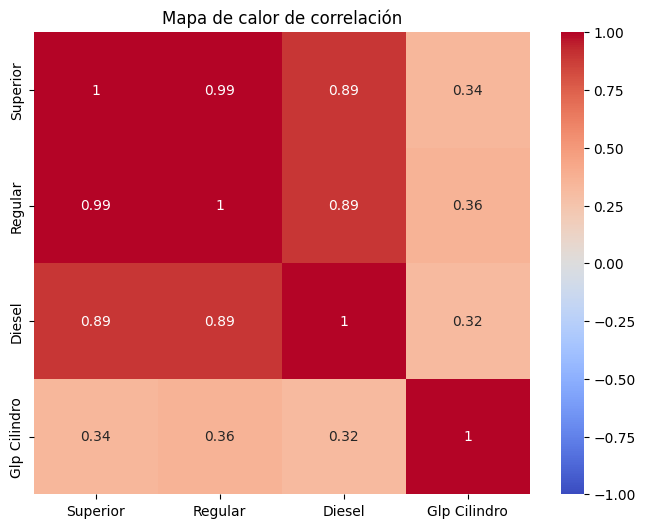

In [57]:

consumo["Glp Cilindro"] = consumo["Glp Cilindro 25Lbs. GTQ/LB"]
columnas_interes = ["Superior", "Regular", "Diesel", "Glp Cilindro"]
consumo_numericas = consumo[columnas_interes]
correlation_matrix = consumo_numericas.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de calor de correlación')
plt.show()

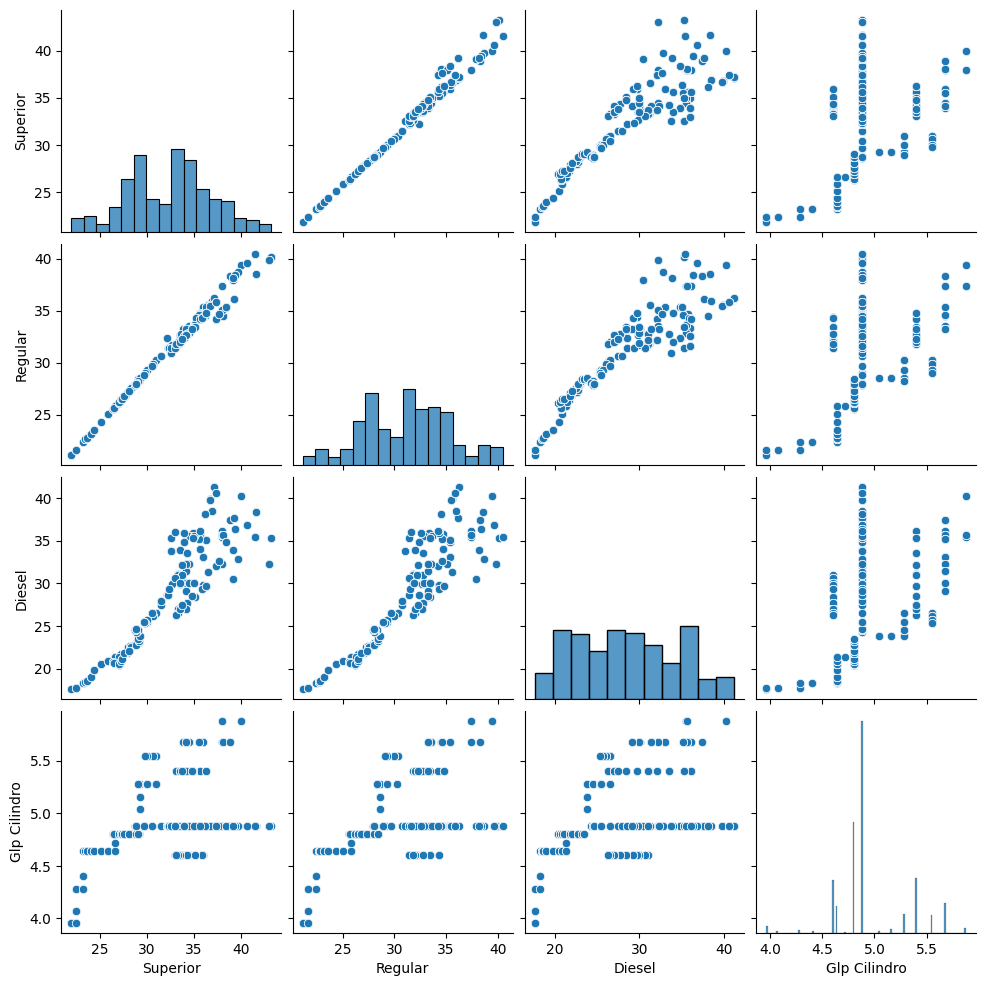

In [58]:
grid = sns.pairplot(consumo_numericas)
plt.show()

In [59]:
normality_test = consumo_numericas.apply(normaltest)
print("Resultados de test de normalidad: \n", normality_test)

Resultados de test de normalidad: 
     Superior   Regular        Diesel  Glp Cilindro
0  13.693900  8.744152  1.781288e+02  6.565420e+01
1   0.001063  0.012625  2.088471e-39  5.538240e-15


Ninguna de las distribuciones de las variables interesantes es normal.

In [60]:
consumo["Mes"] = consumo["FECHA"].dt.month
consumo["Año"] = consumo["FECHA"].dt.year

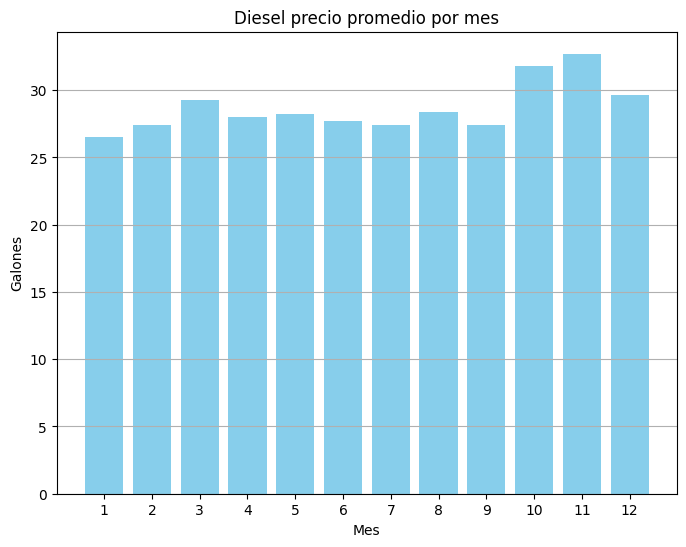

In [61]:
suma_por_mes = consumo.groupby('Mes')['Diesel'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Diesel precio promedio por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

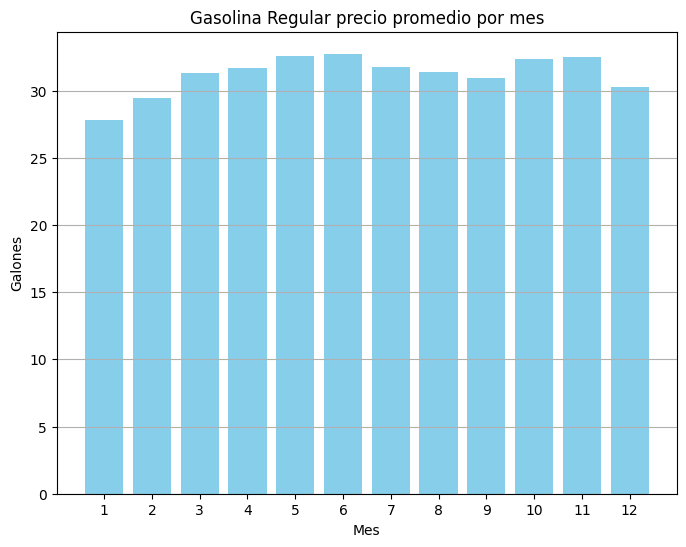

In [62]:
suma_por_mes = consumo.groupby('Mes')['Regular'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina Regular precio promedio por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

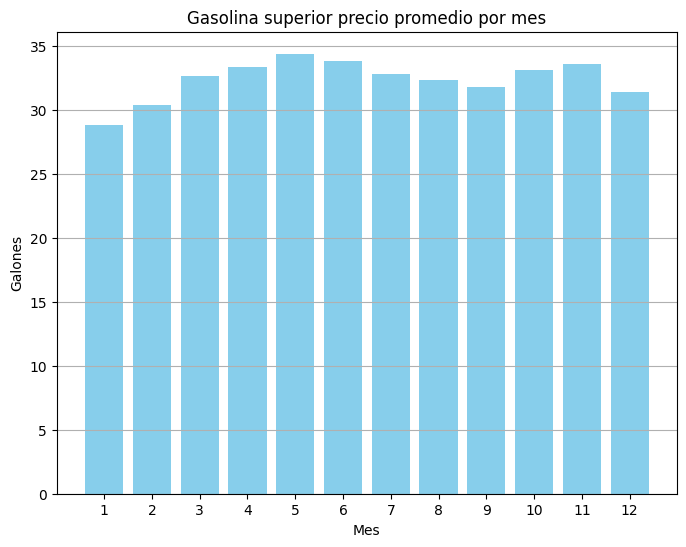

In [63]:
suma_por_mes = consumo.groupby('Mes')['Superior'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina superior precio promedio por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

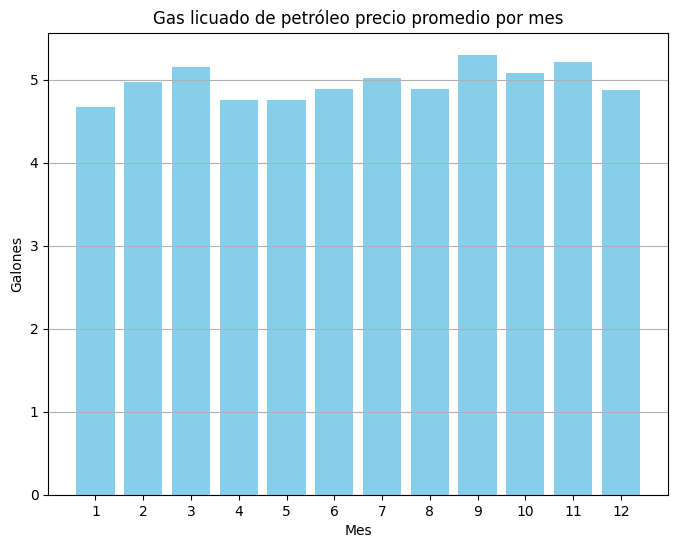

In [64]:
suma_por_mes = consumo.groupby('Mes')['Glp Cilindro'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gas licuado de petróleo precio promedio por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

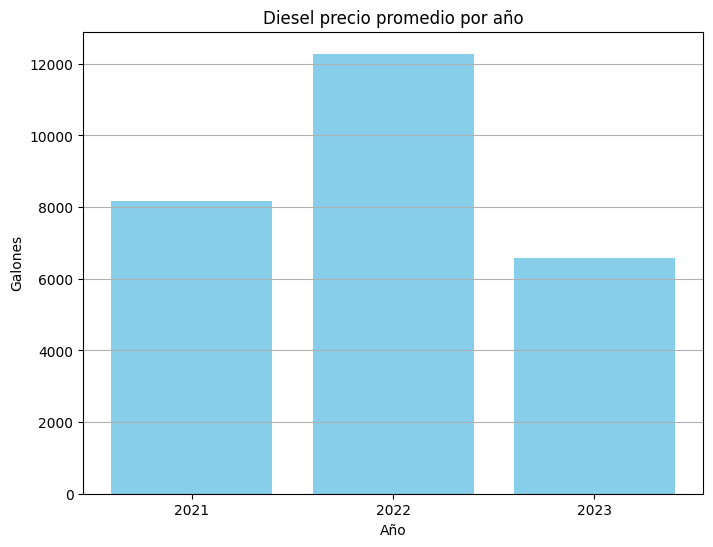

In [65]:
suma_por_mes = consumo.groupby('Año')['Diesel'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Diesel precio promedio por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

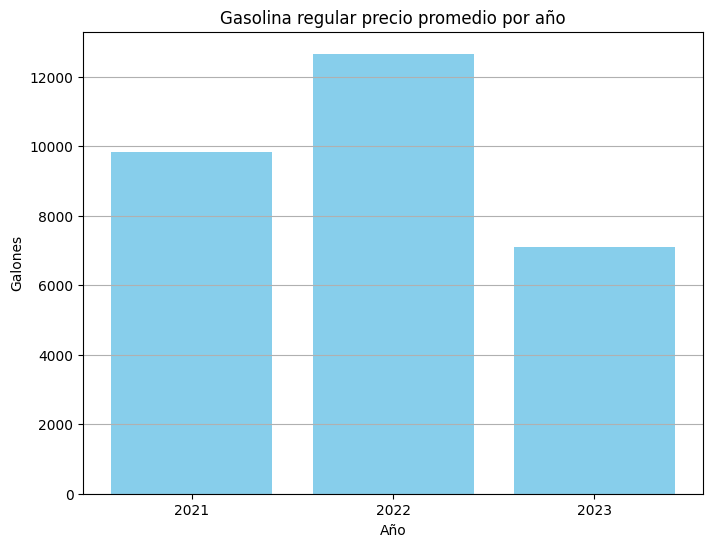

In [66]:
suma_por_mes = consumo.groupby('Año')['Regular'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gasolina regular precio promedio por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

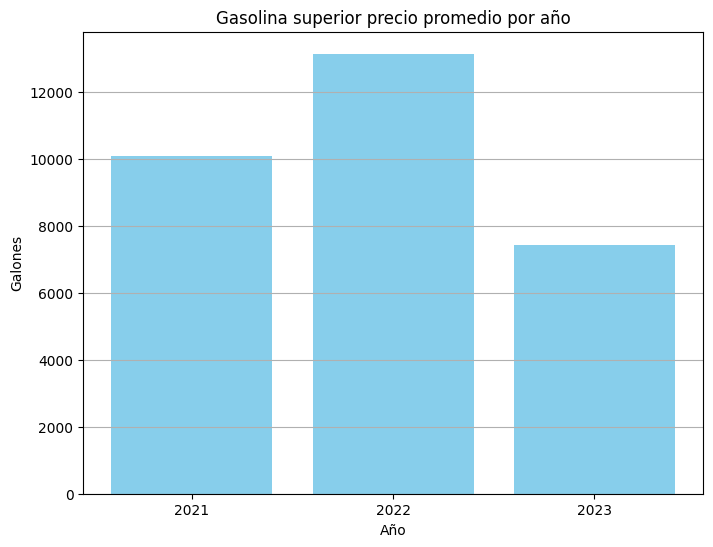

In [67]:
suma_por_mes = consumo.groupby('Año')['Superior'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gasolina superior precio promedio por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

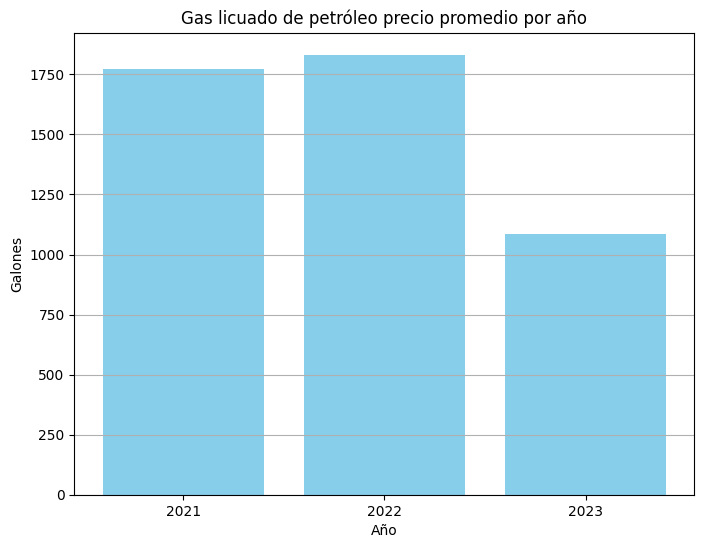

In [68]:
suma_por_mes = consumo.groupby('Año')['Glp Cilindro'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gas licuado de petróleo precio promedio por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

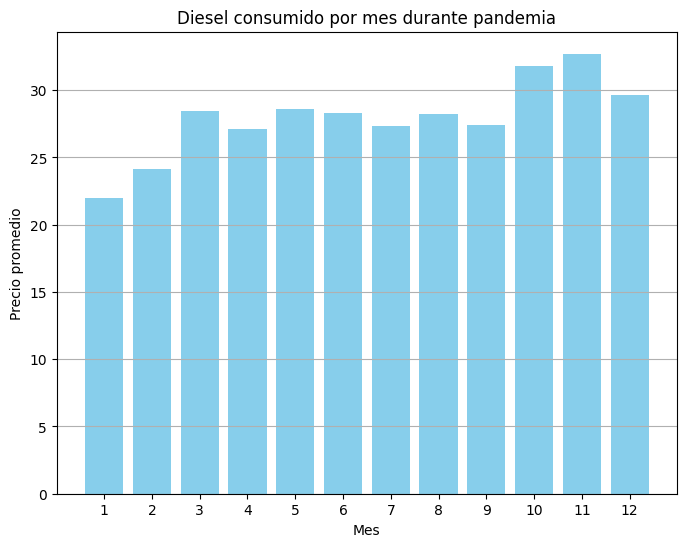

In [69]:
datos_pandemia = consumo[(consumo["FECHA"].dt.year >= 2020) & (consumo["FECHA"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Diesel'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Precio promedio')
plt.title('Diesel consumido por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

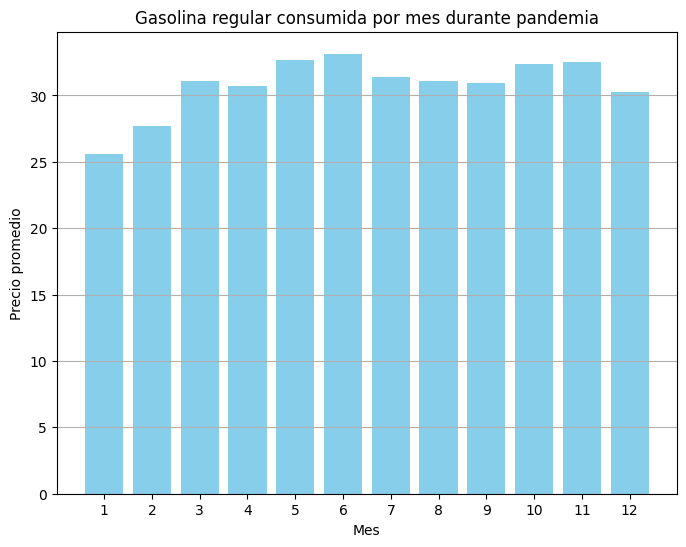

In [70]:
suma_por_mes = datos_pandemia.groupby('Mes')['Regular'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Precio promedio')
plt.title('Gasolina regular consumida por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

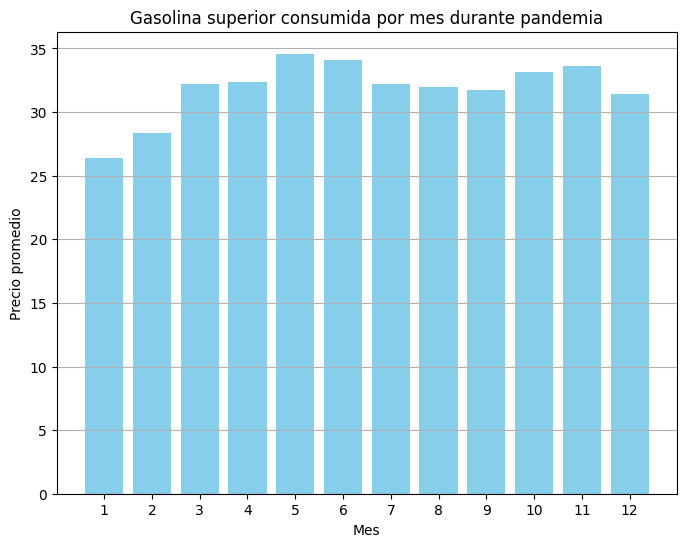

In [71]:
datos_pandemia = consumo[(consumo["FECHA"].dt.year >= 2020) & (consumo["FECHA"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Superior'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Precio promedio')
plt.title('Gasolina superior consumida por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

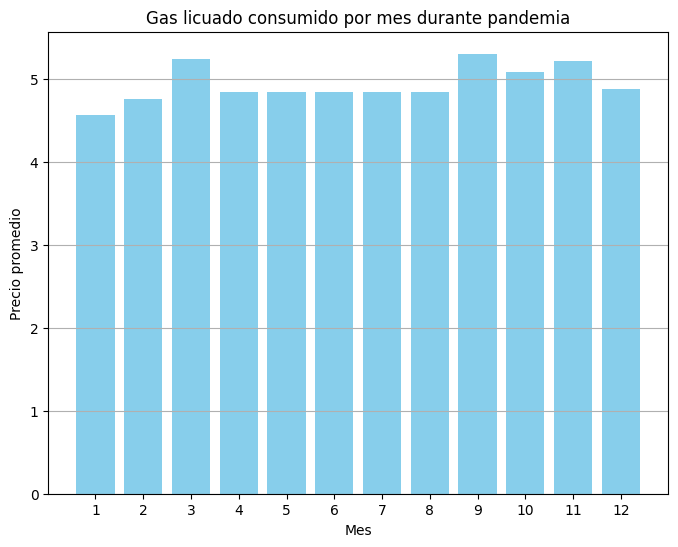

In [72]:
datos_pandemia = consumo[(consumo["FECHA"].dt.year >= 2020) & (consumo["FECHA"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Glp Cilindro'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Precio promedio')
plt.title('Gas licuado consumido por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

## 2. Elección de series de tiempo

* Serie 1: Consumo de diesel
* Serie 2: Importacion de gasolina regular
* Serie 3: Precio de gasolina super

## 3. Análisis de series de tiempo

### 3.1 Consumo de diesel

#### a. Especifique Inicio, fin, y frecuencia.

In [94]:
print("Inicio de frecuencia: ", min(consumo["FECHA"]))
print("Fin de frecuencia: ", max(consumo["FECHA"]))
print("La frecuencia es diaria")

Inicio de frecuencia:  2021-01-01 00:00:00
Fin de frecuencia:  2023-08-06 00:00:00
La frecuencia es diaria


#### b. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

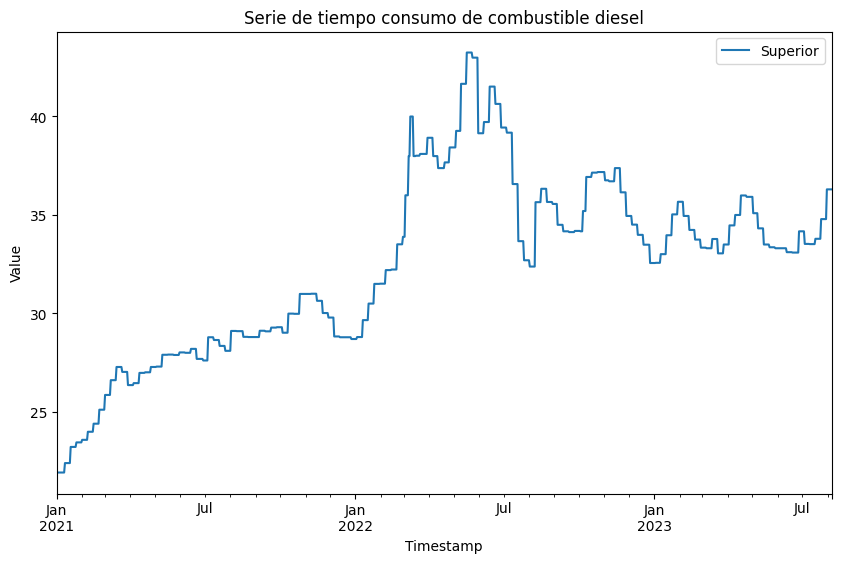

In [74]:
consumo_diesel = consumo[["FECHA", "Superior"]].copy()
# consumo_diesel = consumo_diesel[consumo_diesel["FECHA"].dt.year >= 2020]
consumo_diesel["FECHA"] = pd.to_datetime(consumo_diesel["FECHA"])
consumo_diesel = consumo_diesel.set_index("FECHA")
consumo_diesel.plot(figsize=(10, 6))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo consumo de combustible diesel')
plt.show()

A primera vista se puede observar que existe una tendencia a la alza en la serie de tiempo de consumo de gasolina superior. En junio de 2022 se alcanza un maximo histórico de consumo. Luego en julio vemos que tiene una caida  y rebota en la resistencia de 32 luego de eso el consumo queda encerrado en un canal horizontal donde el piso es 32 y el techo es 37

#### c. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

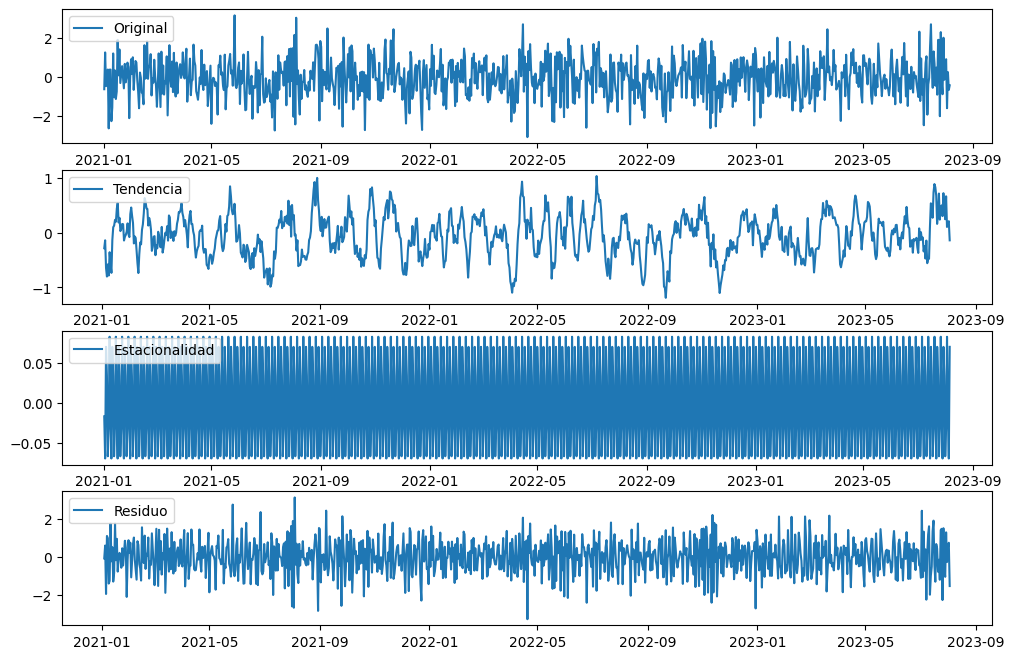

In [75]:
# Crear un índice de fechas para la serie temporal (puedes omitir esta parte si ya tienes un DataFrame con fechas como índice)
date_rng = pd.date_range(start=min(consumo_diesel.index), end=max(consumo_diesel.index), freq='D')
values = np.random.randn(len(date_rng))  # Valores aleatorios para el ejemplo

# Crear el DataFrame con la serie temporal
ts_df = pd.DataFrame(values, index=date_rng, columns=['Value'])

# Realizar la descomposición
result = seasonal_decompose(ts_df['Value'], model='additive', period=7)  # Puedes cambiar 'additive' a 'multiplicative' según la naturaleza de la estacionalidad

# Visualizar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(ts_df['Value'], label='Original')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuo')
plt.legend(loc='upper left')
plt.show()

Los datos muestran que no hay una tendencia fija en el tiempo,tambien por la forma de la grafica podemos que no es estacionaria en media ni en varianza. Si se puede ver un patron en la estacionalidad y os residuos parecieran ser aleatorios

#### d. Determine si es necesario transformar la serie. Explique.

Se aplicará boxcox a la serie para poder hacerla estacionaria en varianza. Como se mencionó, se puede observar en la serie de tiempo diferencias entre las varianzas.

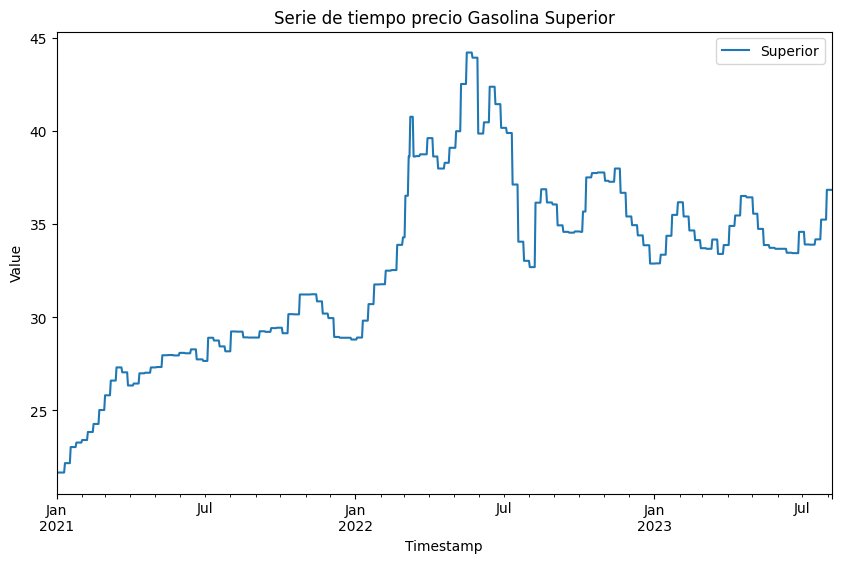

In [76]:
transformed_values, lambda_value = boxcox(consumo_diesel['Superior'])
consumo_diesel['Superior'] = transformed_values
consumo_diesel.plot(figsize=(10, 6))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo precio Gasolina Superior')
plt.show()


#### d. Explique si no es estacionaria en media. Para esto:

##### i. Haga el gráfico de autocorrelación y úselo para explicar la no estacionariedad en media.

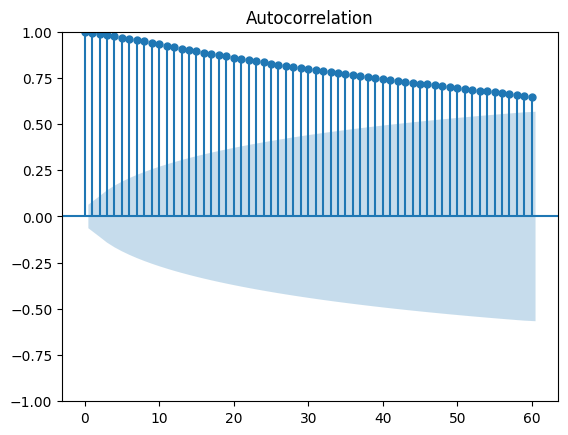

In [77]:
fig = plot_acf(consumo_diesel['Superior'], lags=60)
plt.show()

Se puede observar que los valores de la autocorrelación no decrecen rápidamente a 0. Esto indica que el proceso no es estacionario, porque existe una tendencia en la media.

##### ii. Básese en los valores de estadísticos como la prueba de Dickey-Fuller Aumentada para corroborar la no estacionariedad en media. ¿Qué es necesario hacer para hacerla estacionaria en media en caso de que no lo sea?

In [78]:
def check_stationarity(timeseries):
    # Realizar la prueba ADF
    resultado_adf = adfuller(consumo_diesel)

    # Extraer los resultados importantes de la prueba
    adf_stat = resultado_adf[0]
    p_valor = resultado_adf[1]
    valores_criticos = resultado_adf[4]

    # Imprimir los resultados
    print("Estadístico ADF:", adf_stat)
    print("P-valor:", p_valor)
    print("Valores críticos:")
    for key, value in valores_criticos.items():
        print(f"  {key}: {value}")
check_stationarity(consumo_diesel)

Estadístico ADF: -2.3576143496718975
P-valor: 0.15405840869114057
Valores críticos:
  1%: -3.4373257950466174
  5%: -2.864619627202065
  10%: -2.568409774784971


Por medio de ADF se puede observar que la serie no es estacionaria, al tener un p-value de 0.15, entonces no se puede rechazar la hipótesis nula por lo que se procede a diferenciarla.

In [79]:
consumo_diesel = consumo_diesel.diff().dropna()
check_stationarity(consumo_diesel)

Estadístico ADF: -8.646350172688104
P-valor: 5.258006967441514e-14
Valores críticos:
  1%: -3.4373257950466174
  5%: -2.864619627202065
  10%: -2.568409774784971


Una vez se realizó una diferenciación, se volvió a realizar el test ADF y se logró determinar que ahora la serie de tiempo es estacionaria, al obtener un valor menor a la significancia.

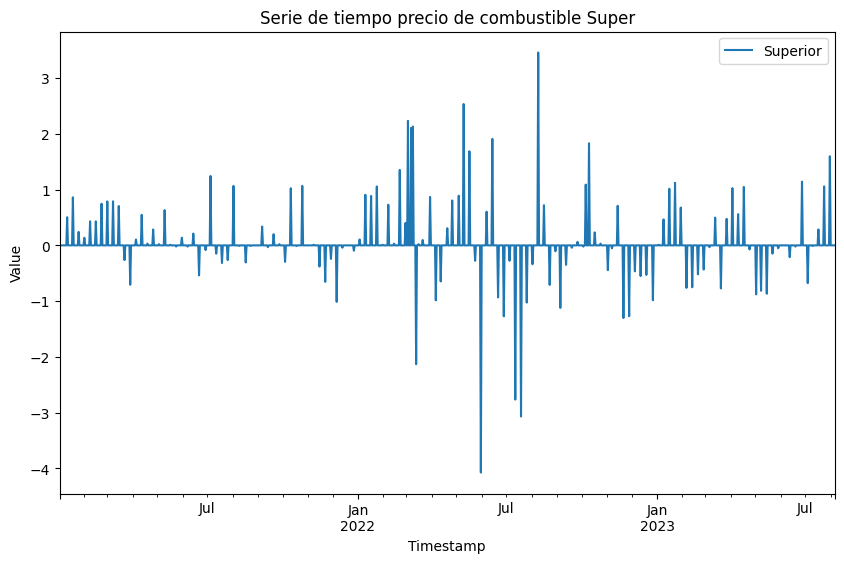

In [82]:
consumo_diesel.plot(figsize=(10, 6))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo precio de combustible Super')
plt.show()

En el gráfico no se puede observar una tendencia, si no que parece ser que la media es constante.

#### f. Una vez analizada la serie, elija los parámetros p, q y d del modelo ARMA o ARIMA que utilizará para predecir. Explique en qué se basó para darle valor a estos parámetros, basándose en las funciones de autocorrelación y autocorrelación parcial. Si usa la función autoarima de R, determine y explique si tiene sentido el modelo propuesto.

### Autocorrelación parcial

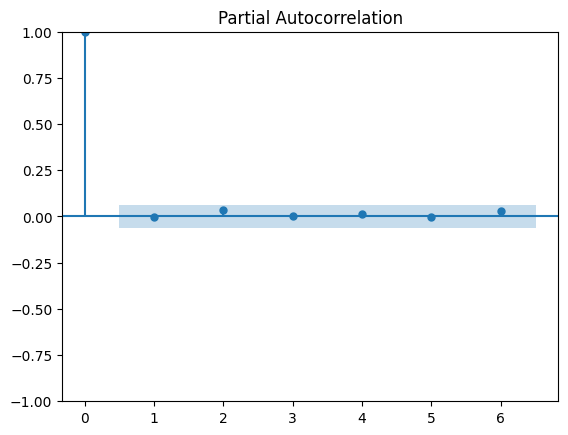

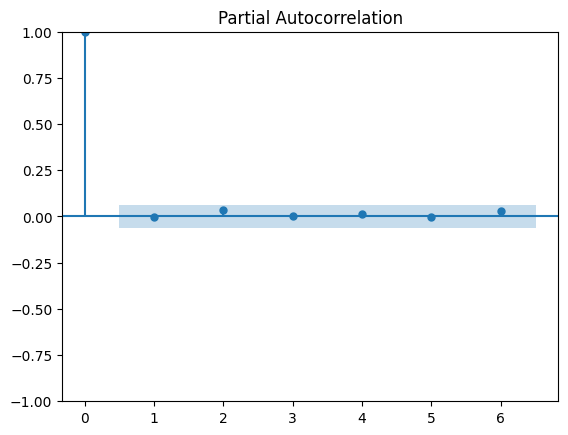

In [102]:
plot_pacf(consumo_diesel, lags=6) #p

### Autocorrelación

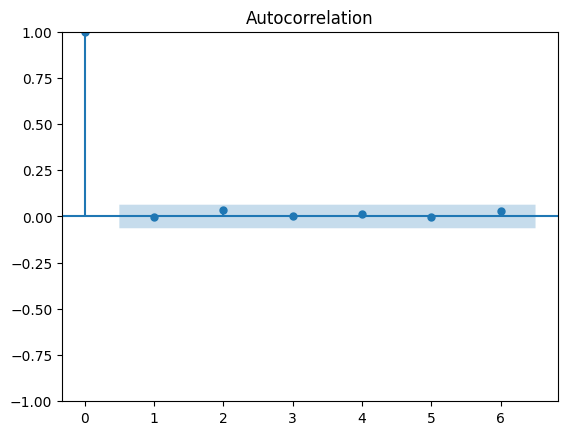

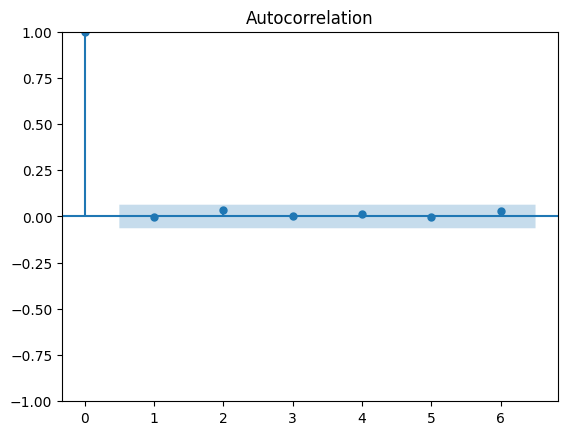

In [101]:
plot_acf(consumo_diesel, lags=6)

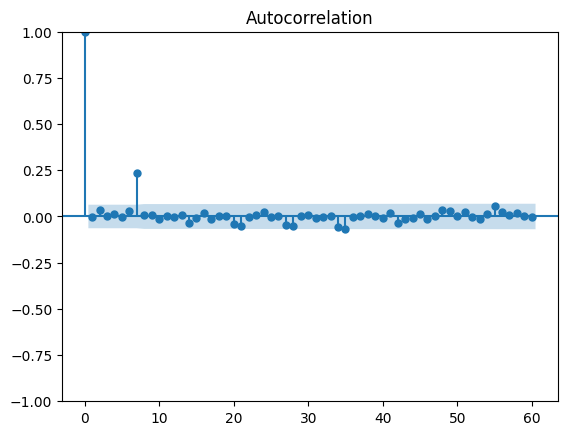

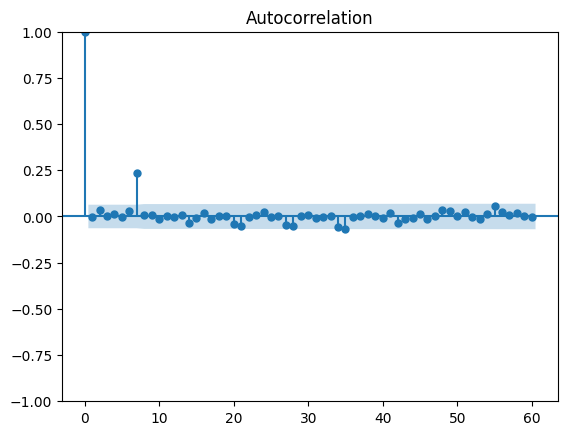

In [122]:
plot_acf(consumo_diesel, lags=60)#q

En el análisis de Autocorrelación no se observa un patrón claro, es importante tomar en cuenta que los datos son diarios, por lo que sería necesario realizar un análisis de autocorrelación con datos mensuales o anuales para poder observar un patrón más claro.

Se crearán dos modelos de ARIMA con parámetros: 
* p = 1, d = 1, q = 2
* p = 2, d = 1, q = 2

In [134]:
modelo1 = SARIMAX(consumo_diesel, order=(1,1,2), seasonal_order=(1,1,0,30), enforce_stationarity=False, enforce_invertibility=False)
resultado_m1 = modelo1.fit()
print(resultado_m1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8162      0.153     -5.332      0.000      -1.116      -0.516
ma.L1          0.1842      5.085      0.036      0.971      -9.782      10.150
ma.L2         -1.1843      6.033     -0.196      0.844     -13.008      10.640
ar.S.L30      -0.4962      0.011    -45.230      0.000      -0.518      -0.475
sigma2         0.1541      0.787      0.196      0.845      -1.389       1.697


In [132]:
modelo2 = SARIMAX(consumo_diesel, order=(2,1,2), seasonal_order=(1,1,0,30), enforce_stationarity=False, enforce_invertibility=False)
resultado_m2 = modelo2.fit()
print(resultado_m2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4694      0.496     -0.947      0.344      -1.441       0.502
ar.L2          0.0216      0.075      0.286      0.775      -0.126       0.169
ma.L1         -0.6145      9.361     -0.066      0.948     -18.962      17.733
ma.L2         -0.3855      3.727     -0.103      0.918      -7.690       6.919
ar.S.L3       -0.5098      0.025    -20.491      0.000      -0.559      -0.461
sigma2         0.2027      1.910      0.106      0.915      -3.540       3.946


### g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos de la serie. Para esto analice los residuos y las métricas AIC y/ BIC.
Los modelos se habían hecho previamente.

#### Modelo 1

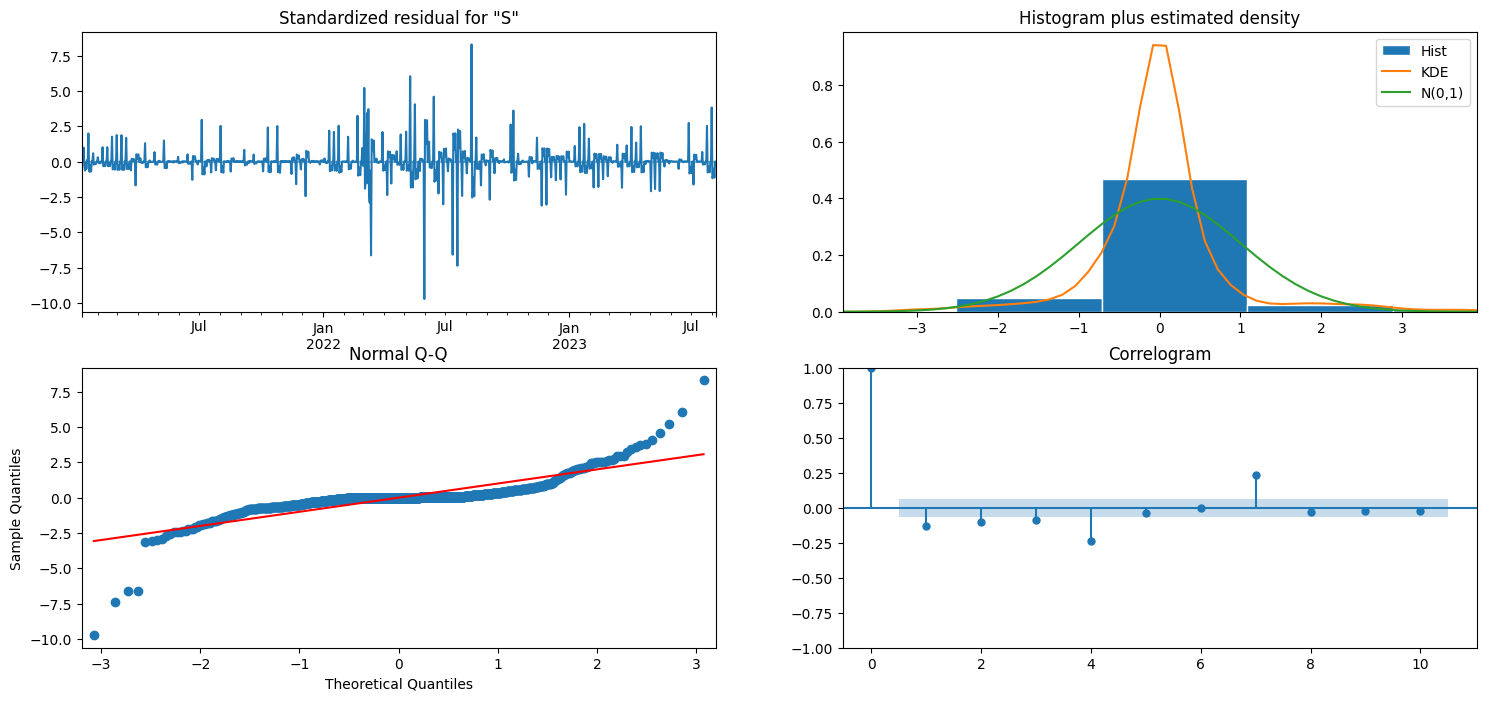

In [129]:
resultado_m1.plot_diagnostics(figsize=(18, 8))
plt.show()

#### Modelo 2

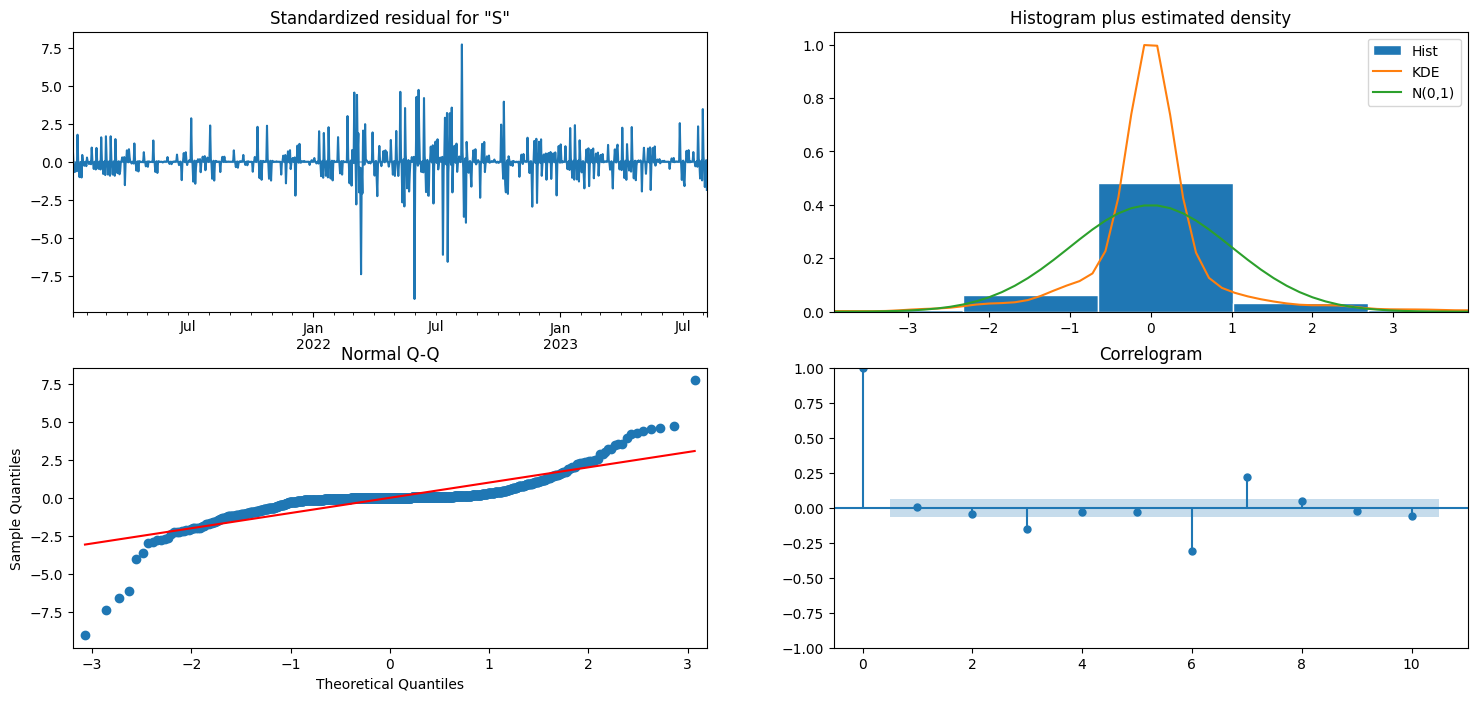

In [133]:
resultado_m2.plot_diagnostics(figsize=(18, 8))
plt.show()